# Importing Libraries

In [1]:
import tensorflow as tf
import pathlib
import PIL.Image

2022-07-10 12:56:52.530142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 12:56:52.530161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

#### Set Directory

In [3]:
data_dir = tf.keras.utils.get_file(origin = dataset_url,
                                  fname = 'flower_photos',
                                  untar = True)

228813984/228813984 [==============================] - 10s 0us/step


In [94]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/home/alex/.keras/datasets/flower_photos')

In [7]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670


# Preview the Dataset

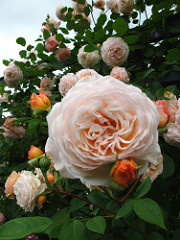

In [8]:
# Rose flowers
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

The .glob (global) module is used to return all file paths that match a specific pattern

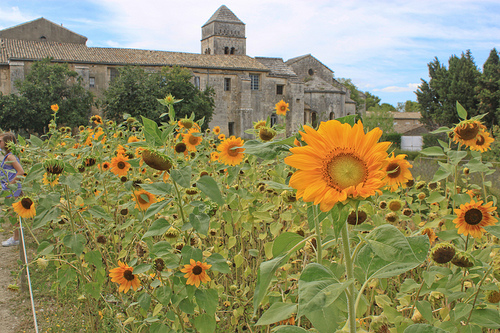

In [9]:
# Sunflowers
sunflowers = list(data_dir.glob("sunflowers/*"))
PIL.Image.open(str(sunflowers[0]))

Previewing Data Directory

In [11]:
!tree ~/.keras/datasets/flower_photos -L 1

/home/alex/.keras/datasets/flower_photos
├── daisy
├── dandelion
├── LICENSE.txt
├── roses
├── sunflowers
└── tulips

5 directories, 1 file


# Creating the Dataset

In [12]:
import os
import numpy as np
import glob
import shutil

import matplotlib.pyplot as plt

Create the necessary classes for the dataset and a hash set holding the number observations for each flower

In [13]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']
sizes = {}

for-loop that creates a training and validation directory with images from all flower folders

In [14]:
for cl in classes:
    img_path = os.path.join(data_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    sizes[cl] = len(images)
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

    for t in train:
        if not os.path.exists(os.path.join(data_dir, 'train', cl)):
            os.makedirs(os.path.join(data_dir, 'train', cl)) 
        shutil.move(t, os.path.join(data_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(data_dir, 'val', cl)):
            os.makedirs(os.path.join(data_dir, 'val', cl))
        shutil.move(v, os.path.join(data_dir, 'val', cl))
print(sizes)

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images
{'roses': 641, 'daisy': 633, 'dandelion': 898, 'sunflowers': 699, 'tulips': 799}


In [64]:
# Find the total number of training and validation observances
full_train = 0
full_val = 0
for key in sizes:
    full_train += round(sizes[key]*0.8)
    full_val += (sizes[key] - round(sizes[key]*0.8))

Create directory paths for training and validation sets

In [85]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Data Augmentation

Keras ImageDataGenerator class lets us augment our images in real-time while the model is still training. We can apply any random transformation on each training image as it is passed to the model. This makes the model robust and also reduces overhead memory. 

The ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

#### Steps for Keras ImageDataGenerator
1. Take a batch of images used for training
2. Apply random transformations to each image in the batch
3. Replace the original batch of images with a new randomly transformed batch
4. Train a DL model on this transormed batch

### Example

In [25]:
# Create directory path to the training set
aug_dir = os.path.join(data_dir,'train')

# ".Path" used to change to a pathlib.PosixPath object instead of keeping string object
aug_dir = pathlib.Path(aug_dir)

tulip_imgs = list(aug_dir.glob("tulips/*"))

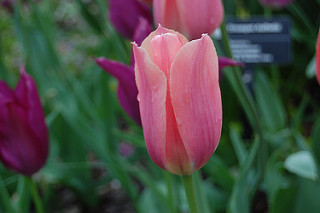

In [42]:
# Before
PIL.Image.open(str(tulip_imgs[7]))

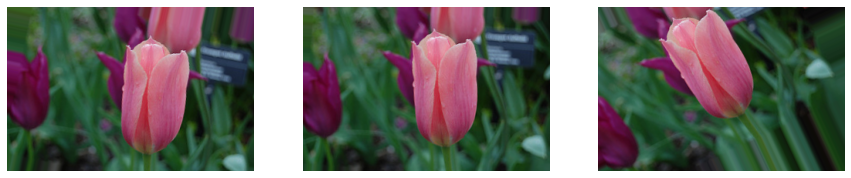

In [54]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# tulip_imgs[7] contains the source path to the .jpg file
img = load_img(tulip_imgs[7])
img = img_to_array(img)
img = np.expand_dims(img, axis = 0)
# ImageDataGenerator rotation
datagen = ImageDataGenerator(rotation_range=30, fill_mode='nearest')

# iterator
aug_iter = datagen.flow(img, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')

## Applying Augmentation on Dataset

In [74]:
# First define our batch size and image shape for later processing
BATCH_SIZE = 100
IMG_SHAPE = (150,150)

# Our training data consists of images of width by height of 150x150

In [68]:
# This function will plot images in the form of a grid with 1 row
# and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#### Flipping Image

The flow_from_directory() method allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data. The method expects that images belonging to different classes are present in different folders but are inside the same parent folder.

In [75]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE
)

Found 2935 images belonging to 5 classes.


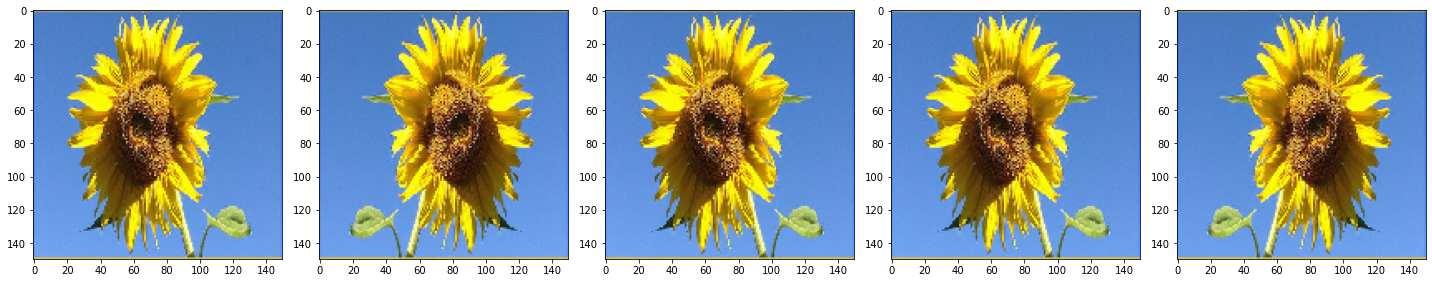

In [76]:
# this creates a temporary list of an original sample image from the training set repeated
# 5 times, and then the augmentation is randomly applied (or not)to each repetition
aug_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(aug_images)

#### Rotating Image

In [77]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=30)

train_data_gen = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE
)

Found 2935 images belonging to 5 classes.


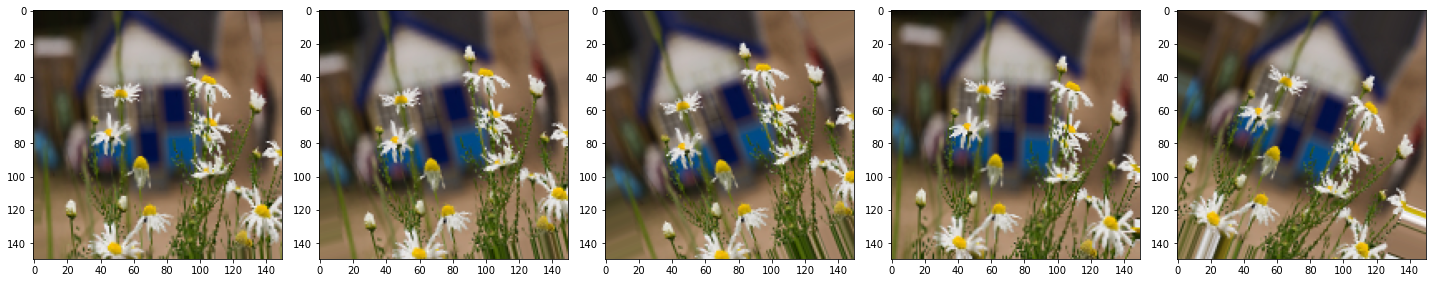

In [78]:
aug_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(aug_images)

#### Zoom on Image

In [79]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE
)

Found 2935 images belonging to 5 classes.


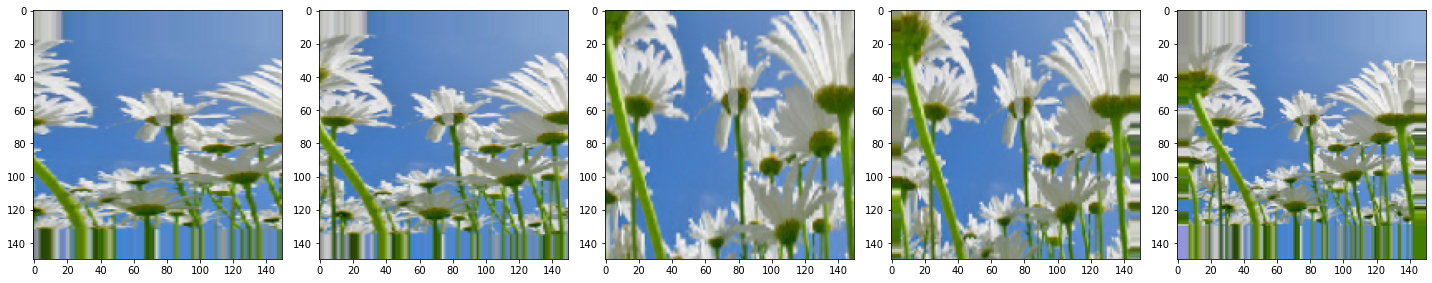

In [80]:
aug_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(aug_images)

## Applied all together

In [82]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=IMG_SHAPE,
    class_mode='binary'
)

Found 2935 images belonging to 5 classes.


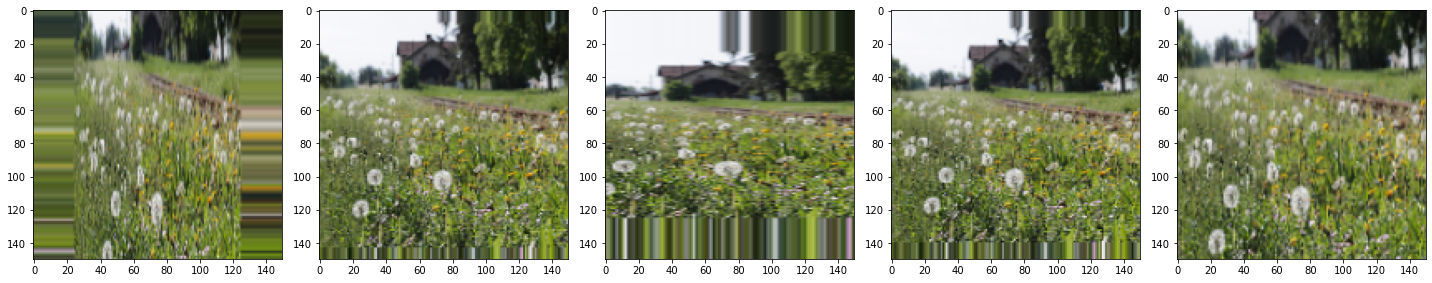

In [83]:
aug_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(aug_images)

### Validation Set Generator

There will be no data augmentation on the validation set as this is the test we want the algorithm to predict, we will just rescale the images to be in the range (0-1)

In [87]:
image_gen_val = ImageDataGenerator(rescale=1.0/255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    target_size=IMG_SHAPE,
    class_mode='binary'
)

Found 735 images belonging to 5 classes.


# Preparing the Convolutional Neural Network

In [88]:
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

In [89]:
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 16)       0

2022-07-11 16:42:54.755992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 16:42:54.756266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 16:42:54.756308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-11 16:42:54.756336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-11 16:42:54.756362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

### Compiling the Model

In [90]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

### Training the Model

In [91]:
EPOCHS = 100
history = model.fit_generator(train_data_gen,
                             steps_per_epoch=int(np.ceil(full_train / float(BATCH_SIZE))),
                             epochs = EPOCHS,
                             validation_data=val_data_gen,
                             validation_steps=int(np.ceil(full_val / float(BATCH_SIZE))))

/tmp/ipykernel_7896/3142198589.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen,


Epoch 1/100


/home/alex/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 22s 735ms/step - loss: 1.5380 - accuracy: 0.3039 - val_loss: 1.3423 - val_accuracy: 0.4340
Epoch 2/100
30/30 [==============================] - 22s 729ms/step - loss: 1.2521 - accuracy: 0.4603 - val_loss: 1.1932 - val_accuracy: 0.5007
Epoch 3/100
30/30 [==============================] - 22s 727ms/step - loss: 1.1556 - accuracy: 0.5152 - val_loss: 1.0949 - val_accuracy: 0.5673
Epoch 4/100
30/30 [==============================] - 22s 722ms/step - loss: 1.0829 - accuracy: 0.5629 - val_loss: 0.9820 - val_accuracy: 0.6068
Epoch 5/100
30/30 [==============================] - 22s 720ms/step - loss: 1.0151 - accuracy: 0.5983 - val_loss: 0.9372 - val_accuracy: 0.6313
Epoch 6/100
30/30 [==============================] - 21s 710ms/step - loss: 0.9749 - accuracy: 0.6147 - val_loss: 0.8995 - val_accuracy: 0.6517
Epoch 7/100
30/30 [==============================] - 22s 713ms/step - loss: 0.9168 - accuracy: 0.6443 - val_loss: 0.9182 - val_accuracy: 0.6558
Epoc

# Plotting Train and Validation Graphs

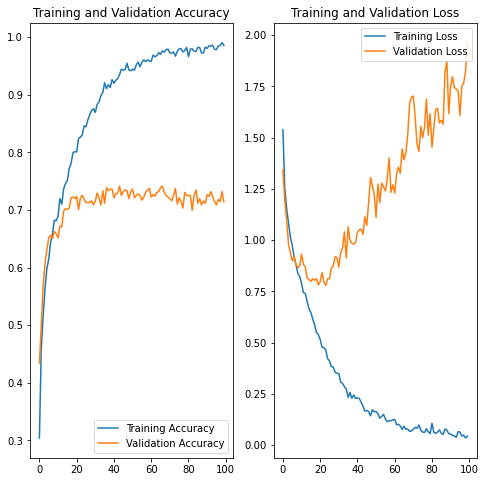

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()